# Ripple Report

## Introduction

In December of 2017, cryptocurrency became a popular topic of conversation after Bitcoin reached an all time high price of \\$19,783 per coin from only about \\$1,000 at the start of the year. Riding the wave of popularity of Bitcoin were other cryptocurrencies such as Ethereum, Ripple, and Litecoin. Not many people understood the technology behind these cryptocurrencies, but many saw it as an oppurtunity to get very rich in a short amount of time. 

I was one of those who jumped into cryptocurrency expecting to get rich. I did not go after Bitcoin however because I thought that there would be other coins with better technology and potential for growth. What caught my attention was a coin whose price was under $1 per coin and whose technology was being tested by Japanese and South Korean banks: Ripple (XRP). As soon as I could have, I put a significant amount (that I was still willing to lose) of my own money into XRP; in a short time after, I lost over half that amount.

This experience unfortunately is not uncommon, especially with amateur investors. What draws in new people into investing is the prospect of making money. However, this prospect comes along with the risk of losing a portion &mdash; big or small &mdash; of one's investment. Therefore, before investing in anything, one should always take into consideration what they would be willing to lose.

My motivation behind this project is to help out someone who is in the same position as I was in previously when it comes to investing in XRP. Therefore, there are two parts to my analysis: first, I will predict the price of XRP using ARIMA modeling, second, I will use GARCH models to model the changing variances of XRP and use that to model worst and best case scenarios for when real price observations deviate from my predictions.

## Loading Libraries

In [33]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as tsap
import statsmodels.tsa as tsa
%matplotlib inline

## Data Importation

For my analysis, minute to minute XRP price (in USD) data was obtained through the API at https://min-api.cryptocompare.com/, and stored into .csv's. A training set of data from July 7th, 2018, 14:40 (UTC) to July 9th, 2018, 00:00 (UTC) (2001 observations) is used to create my model for prediction. In order to verify these observations, 2001 observations from July 9th, 2018, 00:00 (UTC) to July 10th, 09:20 (UTC) is used. 

In [34]:
ripple_m = pd.read_csv("data/XRP_to_USDminute.csv", index_col=0)
ripple_m_verif = pd.read_csv("data/XRP_to_USD_verfication.csv", index_col=0)

I want to verify that the verification set starts where the training set ends.

In [35]:
ripple_m.tail()

,close,high,low,open,time,volumefrom,volumeto
1996,0.4786,0.4786,0.4783,0.4783,2018-07-08 23:56:00,7093.60,3393.28
1997,0.4782,0.4786,0.4782,0.4786,2018-07-08 23:57:00,2809.50,1344.77
1998,0.4783,0.4785,0.4782,0.4782,2018-07-08 23:58:00,6813.00,3260.91
1999,0.4782,0.4784,0.4782,0.4783,2018-07-08 23:59:00,7700.25,3684.50
2000,0.4773,0.4783,0.4773,0.4782,2018-07-09 00:00:00,51127.53,24433.76


In [36]:
ripple_m_verif.head()

,close,high,low,open,time,volumefrom,volumeto
0,0.4773,0.4783,0.4773,0.4782,2018-07-09 00:00:00,51127.53,24433.76
1,0.4774,0.4774,0.4771,0.4773,2018-07-09 00:01:00,9309.90,4444.80
2,0.4770,0.4774,0.4769,0.4774,2018-07-09 00:02:00,47729.40,22771.34
3,0.4772,0.4774,0.4769,0.4770,2018-07-09 00:03:00,632.52,304.39
4,0.4770,0.4772,0.4770,0.4772,2018-07-09 00:04:00,16261.44,7755.50


## Plotting the Data

In [37]:
ts_m = ripple_m.set_index('time')['close']

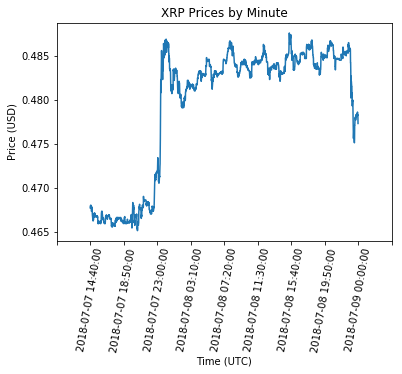

In [38]:
ts_m.plot(title='XRP Prices by Minute')
plt.ylabel('Price (USD)')
plt.xlabel('Time (UTC)')
locs = plt.xticks()[0]
labels = []
for l in locs:
    if 0 <= l < len(ts_m):
        labels.append(ts_m.index[int(l)])
    else:
        labels.append('')
plt.xticks(locs, labels, rotation=80)
plt.show()

Looking at this initial graph, one could say that there is an increasing trend. Most of the increase however came suddenly around 2018-07-07 23:00.

## ARIMA Modeling

The autoregressive integrated moving average (ARIMA) model is one of the most popular and commonly used models for dealing with time series data. Specific details about it can be read about on [Wikipedia](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average). A quick summary of it is that it is a statistical model that models future values based off of past values (autoregressive part) and past errors (moving average part). The "I" in ARIMA refers to how the model is fitted on the differenced data, rather than the raw data values themselves. The model that is fit on the already differenced data can simply be refered to as an ARMA model.

The formula for an ARMA(p,q) model is $X_t = \alpha_{1}X_{t-1} + \ldots + \alpha_{p}X_{t-p} + \epsilon_{t} + \theta_{1}\epsilon_{t-1} + \ldots + \theta_{q}\epsilon_{t-q}$

In order for an ARIMA model to be suitable, there are several requirements that the data has to have:
    1. Constant mean
    2. Constant variance (homoscedasticity)
    3. Constant autocorrelations between observations
    
Any set of data that has these traits is considered stationary. In reality, very little data will ever be completely stationary, especially financial data, and no statistical model will ever be perfect. However, there are a variety of transformations that can be performed on data that can make it more stationary, and there are adjustments to statistical models that can be done to make them better.

When trying to create a model for time series, there is one very commonly used process called the Box-Jenkins Methodology, whose steps are as follows:
    1. Prepare data to make it stationary
    2. Examine autocorrelation function (ACF) and partial autocorrelation function (PACF) graphs to identify potential models
    3. Estimate parameters of potential models, and compare using various criteria
    4. Perform diagnostic checking on the residuals
    5. Forecast

I will be following Box-Jenkins Methodlogy in this analysis, so therefore I will start with transforming the price data in order to find a more stationary time series. When it comes to financial data (such as stock, cryptocurrency, or gold prices), a common approach is to use the log-returns of prices, because it is closer to being normal than just regular returns or raw price changes.

In [39]:
ts_logre = np.log(ts_m) - np.log(ts_m.shift(1))

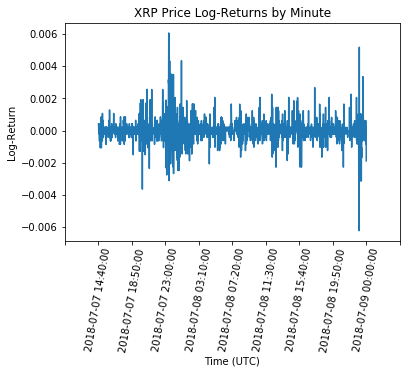

In [40]:
ts_logre.plot(title='XRP Price Log-Returns by Minute')
plt.ylabel('Log-Return')
plt.xlabel('Time (UTC)')
locs = plt.xticks()[0]
labels = []
for l in locs:
    if 0 <= l < len(ts_logre):
        labels.append(ts_logre.index[int(l)])
    else:
        labels.append('')
plt.xticks(locs, labels, rotation=80)
plt.show()

In order to better visualize the periods of different volatility, I create a time series of the variance within 200 10-minute time periods.

In [41]:
df = ts_logre.dropna()
ts_var = pd.Series()
for i in range(200):
    start = i*10
    end = (i+1)*10
    x = pd.Series(df[start:end].var(), index=[df.index[start]])
    ts_var = ts_var.append(x)

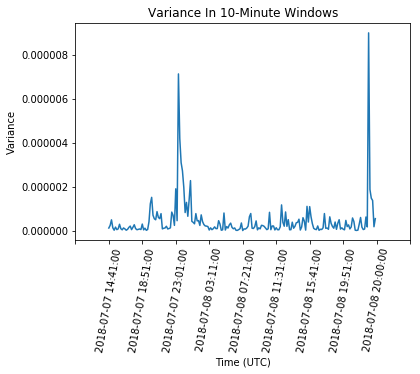

In [42]:
ts_var.plot(title='Variance In 10-Minute Windows')
plt.ylabel('Variance')
plt.xlabel('Time (UTC)')
locs = plt.xticks()[0]
labels = []
for l in locs:
    if 0 <= l < len(ts_var):
        labels.append(ts_var.index[int(l)])
    else:
        labels.append('')
labels.insert(-2, '2018-07-08 20:00:00')
plt.xticks(locs, labels, rotation=80)
plt.show()

Indeed, the variance is not always constant. It appears that whenever the variance does spike up a lot, it very quickly normalizes again. Despite the non-constant variance however, I will proceed with diagnostic checking for the data and go onto the next step: looking at the autocorrelation function (ACF) and partial autocorrelation function (PACF) graphs.

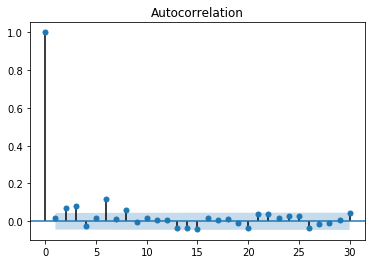

In [43]:
x = tsap.plot_acf(ts_logre.dropna(), lags=30) # need to assign to variable otherwise it plots two plots

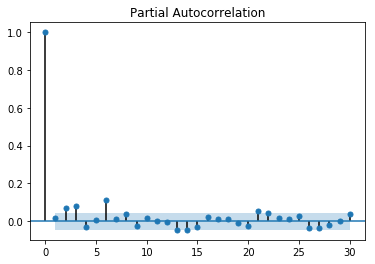

In [44]:
x = tsap.plot_pacf(ts_logre.dropna(), lags=30)

There are several lags in which the ACF and PACF functions seem significantly outside the 95 percent confidence interval, e.g. the 2nd, 3rd, and 6th lags. However, this does not seem consistent with any particular degree ARIMA model. Nonetheless, I will attempt to take AICc of multiple ARMA(p,q) models for p=0,1,2,3 and q=0,1,2,3 and see if any of the models have a lower AICc than an ARMA(0,0) (i.e. white noise) model.

In [45]:
warnings.simplefilter('ignore')
aics = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        model = tsa.arima_model.ARMA(ts_logre.dropna(), order=(i,j))
        model_fit = model.fit(disp=0) # disp=0 to omit displaying errors
        aics[i,j] = round(model_fit.aic, 2)

In [46]:
aics

array([[-23492.1 , -23490.48, -23499.01, -23507.57],
       [-23490.54, -23490.51, -23508.5 , -23507.39],
       [-23498.66, -23508.61, -23502.02, -23513.17],
       [-23509.36, -23507.56, -23505.56, -23516.94]])

The ARMA(3,3) model appears to have the lowest AIC, however I believe that an ARMA(3,3) model would not perform significantly better than a white noise model. I create two models, the first being $X_t = \epsilon_{t}$, where $\epsilon_{t} \sim  N(0, \sigma^2)$, (I will let $\sigma^2$ be equal to a constant, the average variance, for now). The second model is $X_t = \alpha_{1}X_{t-1} + \theta_{2}X_{t-2} + \alpha_{3}X_{t-3} + \epsilon_{t} + \theta_{1}\epsilon_{t-1} + \theta_{2}\epsilon_{t-2} + \theta_{3}\epsilon_{t-3}$, where again $\epsilon_{t} \sim  N(0, \sigma^2)$.

By the documentation of the arima_model.ARMA.fit function, the coefficients for the $\alpha's$ and $\theta's$ are found using the exact maximum likelihood via Kalman filter.

In [47]:
warnings.simplefilter('ignore')
model2 = tsa.arima_model.ARMA(ts_logre.dropna(), order=(3,3))
model2_fit = model2.fit(disp=0)

In [48]:
model2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  close   No. Observations:                 2000
Model:                     ARMA(3, 3)   Log Likelihood               11766.472
Method:                       css-mle   S.D. of innovations              0.001
Date:                Sun, 26 Aug 2018   AIC                         -23516.944
Time:                        17:31:57   BIC                         -23472.137
Sample:                    07-07-2018   HQIC                        -23500.492
                         - 07-09-2018                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        9.857e-06   2.03e-05      0.485      0.628      -3e-05    4.97e-05
ar.L1.close     0.0704      0.161      0.438      0.661      -0.245       0.385
ar.L2.close    -0.0928      0.122     -0.763      0.445      -0.331       0.146
ar.L3.close     0.5925      0.119      4.985      0.000       0.360       0.825
ma.L1.close    -0.0735      0.169     -0.436      0.663      -0.404       0.257
ma.L2.close     0.1656      0.129      1.279      0.201      -0.088       0.419
ma.L3.close    -0.5117      0.123     -4.158      0.000      -0.753      -0.270
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5269           -1.0567j            1.1808           -0.3236
AR.2           -0.5269           +1.0567j            1.1808            0.3236
AR.3            1.2105           -0.0000j            1.2105           -0.0000
MA.1           -0.5013           -1.1055j            1.2139           -0.3178
MA.2           -0.5013           +1.1055j            1.2139            0.3178
MA.3            1.3263           -0.0000j            1.3263           -0.0000
-----------------------------------------------------------------------------
"""

Therefore, the second model is $X_t = 0.0704X_{t-1} -0.0928X_{t-2} + 0.5925X_{t-3} + \epsilon_{t} -0.0735\epsilon_{t-1} + 0.1656\epsilon_{t-2} -0.5117\epsilon_{t-3}$

First, I plot the white noise model's predictions and 95% confidence interval on top of the test set (next 110 observations) in order to visualize its prediction accuracy.

In [49]:
variance = ts_logre.dropna().var()
pred1 = [0] * 110
upp1 = 1.96*np.sqrt(variance) + pred1
low1 = -1.96*np.sqrt(variance) + pred1

In [50]:
ts_verif = ripple_m_verif.set_index('time')['close']
ts_logre_verif = np.log(ts_verif) - np.log(ts_verif.shift(1))

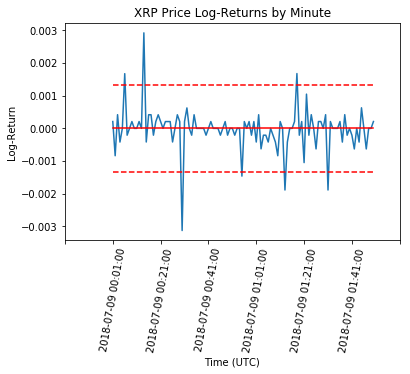

In [51]:
ts_logre_verif.dropna().head(110).plot(title='XRP Price Log-Returns by Minute')
plt.plot(pred1, 'r-')
plt.plot(upp1, 'r--')
plt.plot(low1, 'r--')
plt.ylabel('Log-Return')
plt.xlabel('Time (UTC)')
locs = plt.xticks()[0]
labels = []
for l in locs:
    if 0 <= l < len(ts_logre_verif.dropna()):
        labels.append(ts_logre_verif.dropna().index[int(l)])
    else:
        labels.append('')
labels[-1] = ''
plt.xticks(locs, labels, rotation=80)
plt.show()

It appears that a majority of the log-returns are within the 95% confidence interval of a white noise model, but during periods of high volatility, there are many more observations outside the bounds. Next, I will plot the fitted values of the ARMA(3,3) model on the training set.

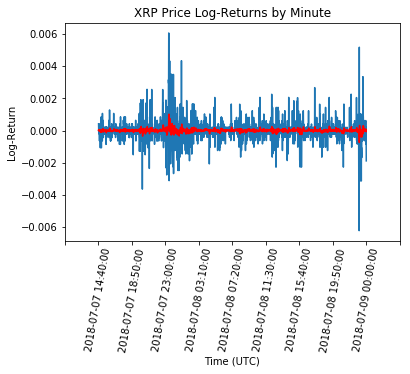

In [52]:
pred2 = model2_fit.predict().values
ts_logre.plot(title='XRP Price Log-Returns by Minute')
plt.plot(pred2, 'r-')
plt.ylabel('Log-Return')
plt.xlabel('Time (UTC)')
locs = plt.xticks()[0]
labels = []
for l in locs:
    if 0 <= l < len(ts_logre):
        labels.append(ts_logre.index[int(l)])
    else:
        labels.append('')
plt.xticks(locs, labels, rotation=80)
plt.show()

The model's fit is clearly fairly conservative when estimating that there will be large spikes in log-return.

And now, I plot the forecasts and 95% confidence interval for the next 110 observations. After each observation, the model is re-fit to forecast the next observation.

In [53]:
import datetime
warnings.simplefilter('ignore')
ts = ts_logre_verif.dropna().head(110)
training = ts_logre.dropna()

pred = []
upp = []
low = []

for i in range(len(ts)):
    # making model and prediction for all previous observations
    model = tsa.arima_model.ARMA(training, order=(3,3))
    modelfit = model.fit(disp=0)
    forecast = modelfit.forecast(1)
    pred.append(forecast[0][0])
    upp.append(forecast[2][:,1])
    low.append(forecast[2][:,0])
    
    # updating training set with true value
    time = datetime.datetime.strptime(training.index[-1], '%Y-%m-%d %H:%M:%S') + datetime.timedelta(minutes=1)
    time_string = datetime.datetime.strftime(time, '%Y-%m-%d %H:%M:%S')
    s = pd.Series([ts[i]], [time_string])
    training = training.append(s)

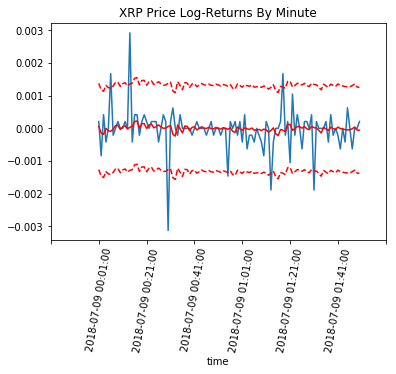

In [54]:
ts.plot(title="XRP Price Log-Returns By Minute")
plt.plot(pred, 'r-')
plt.plot(upp, 'r--')
plt.plot(low, 'r--')
locs = plt.xticks()[0]
labels = []
for l in locs:
    if 0 <= l < len(ts):
        labels.append(ts.index[int(l)])
    else:
        labels.append('')
plt.xticks(locs, labels, rotation=80)
plt.show()

I want to see if this ARMA(3,3) model performed better than the white noise model. Therefore, I look at the squared differences between the predicted and real values.

In [55]:
np.mean(np.square(ts)) # average squared differences in white noise model

4.0184515543756755e-07

In [56]:
np.mean(np.square(ts - pred)) # average squared differences in the ARMA(3,3) model

4.0804082809071906e-07

Although the average squared differences are not significantly different in the two models, the ARMA(3,3) model does have slightly larger squared differences. Therefore, I consider the white noise better as better than the ARMA(3,3) model for prediction.

However, if that is the case, that means that there is no significant predictions that one can make on XRP prices on a minute-to-minute basis. Thankfully, prices are not all that matters when it comes to analysis of prices. There is another significant measurement that financial analysts are interested in: variance.

## GARCH Modeling

Previously, the white noise model is defined such that $X_t = \epsilon_{t}$, where $\epsilon_{t} \sim  N(0, \sigma^2)$, and $\sigma^2$ is a constant. However, as we have seen, variance is not always constant.

Therefore, we adjust model so that $\sigma^2$ is not a constant, but rather modeled by (in a GARCH(p,q) model) $\sigma^2 = \omega + \alpha_{1}\epsilon_{t-1}^2 + \ldots + \alpha_{p}\epsilon_{t-p}^2 + \beta_{1}\sigma_{t-1}^2 + \ldots + \beta_{q}\sigma_{t-q}^2$.

Generally, neither p nor q exceed 2.

In [57]:
from arch import arch_model
ts = ts_logre.dropna()*100 # multiply by 100 because fit fails if values are too close to 0
# fitting a GARCH(1,1) model first, since that always performs fairly well
am = arch_model(ts, mean='zero', power=2.0)
res = am.fit(update_freq=0, show_warning=False)
res.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2956.813118415273
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2956.81
Distribution:                  Normal   AIC:                          -5907.63
Method:            Maximum Likelihood   BIC:                          -5890.82
                                        No. Observations:                 2000
Date:                Sun, Aug 26 2018   Df Residuals:                     1997
Time:                        17:34:00   Df Model:                            3
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.4105e-04  5.460e-05      2.583  9.789e-03 [3.403e-05,2.481e-04]
alpha[1]       0.0949  2.983e-02      3.180  1.473e-03   [3.639e-02,  0.153]
beta[1]        0.8714  3.745e-02     23.268 9.426e-120     [  0.798,  0.945]
============================================================================

Covariance estimator: robust
"""

Looking at the summary of the GARCH(1,1) model, there is a P>|t| of 9.426e-120 for beta[1], indicating that there is a very significant dependence of one period's variance on the previous period's variance.

Generally, the GARCH model is good enough to interpret how the variance of a time series changes. However, for the purposes of fit and prediction, there are models based off of the GARCH model that can perform slightly better.

First, I will stick with the GARCH(p,q) model, but will change values of p and q and compare AICs. The AIC to beat, that of GARCH(1,1), is -5907.63.

In [58]:
aics_norm = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        if i == 0:
            aics_norm[i,j] = 0 # either p or o has to be greater than 0
        else:
            am = arch_model(ts, p=i, o=0, q=j, dist='normal', mean='zero', power=2.0)
            res = am.fit(update_freq=0, show_warning=False)
            aics_norm[i,j] = res.aic
aics_norm

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2786.576504043812
            Iterations: 10
            Function evaluations: 43
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2956.813118415273
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -2952.4495769346277
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2851.039690019217
            Iterations: 13
            Function evaluations: 73
            Gradient evaluations: 13
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -2936.59013591206
            Iterations: 5
      

array([[    0.        ,     0.        ,     0.        ],
       [-5569.15300809, -5907.62623683, -5896.89915387],
       [-5696.07938004, -5865.18027182, -5910.0976924 ]])

I am hesitant to use the models which, when fit, returned exit mode 8. Therefore, I do not consider the GARCH(1,2) or GARCH(2,1) models. Nonetheless, the only GARCH(p,q) model that has a lower AIC than the GARCH(1,1) model is the GARCH(2,2) model. Because of the case of prefering simpler models over complex ones unless there's a significant improvement, I still stick with the GARCH(1,1) model.

Next, I consider the case where we also take into account not just the magnitude of the variance, but also the direction of the standard deviation, i.e. I am taking into consideration the asymmetric effect of the returns. It is theorized that in financial markets, negative returns create more volatility than positive returns.

The adjusted GARCH model would then be $\sigma^2 = \omega + \alpha_{1}\epsilon_{t-1}^2 + \ldots + \alpha_{p}\epsilon_{t-p}^2 + \gamma\epsilon_{t-1}^2I[\epsilon_{t-1}<0] + \beta_{1}\sigma_{t-1}^2 + \ldots + \beta_{q}\sigma_{t-q}^2$.

In [59]:
aics_norm = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        am = arch_model(ts, p=i, o=1, q=j, dist='normal', mean='zero', power=2.0)
        res = am.fit(update_freq=0, show_warning=False)
        aics_norm[i,j] = res.aic
aics_norm

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -2430.9327951521927
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -2858.0525416127452
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -2856.0886242214438
            Iterations: 7
            Function evaluations: 27
            Gradient evaluations: 3
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -2750.8899197322935
            Iterations: 6
            Function evaluations: 12
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2960.8588874945854
            Ite

array([[-4857.8655903 , -5710.10508323, -5704.17724844],
       [-5495.77983946, -5913.71777499, -5917.76175959],
       [-5694.1036786 , -5911.71777535, -5879.86238357]])

Again, I only consider models which did not return "Exit mode 8". The lowest AIC when there is an asymmetric component is for the GARCH(1,1,2) model, (AIC of -5917.76).

In [60]:
am = arch_model(ts, p=1, o=1, q=2, dist='normal', mean='zero', power=2.0)
res = am.fit(update_freq=0, show_warning=False)
res.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2963.8808797964193
            Iterations: 13
            Function evaluations: 107
            Gradient evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Zero Mean - GJR-GARCH Model Results                      
==============================================================================
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                2963.88
Distribution:                  Normal   AIC:                          -5917.76
Method:            Maximum Likelihood   BIC:                          -5889.76
                                        No. Observations:                 2000
Date:                Sun, Aug 26 2018   Df Residuals:                     1995
Time:                        17:34:01   Df Model:                            5
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.8529e-04  6.652e-05      2.786  5.343e-03 [5.492e-05,3.157e-04]
alpha[1]       0.0979  3.141e-02      3.116  1.831e-03   [3.632e-02,  0.159]
gamma[1]       0.0648  4.983e-02      1.300      0.194  [-3.288e-02,  0.162]
beta[1]        0.5232      0.122      4.272  1.936e-05     [  0.283,  0.763]
beta[2]        0.3053      0.112      2.722  6.493e-03   [8.545e-02,  0.525]
============================================================================

Covariance estimator: robust
"""

One final adjustment I will make is assuming a Student's T-distribution rather than a Normal distribution, and raising $\sigma$ to the first power rather than the second. Thus, the model I am looking for is of the form $\sigma_t = \omega + \alpha_{1}|\epsilon_{t-1}| + \ldots + \alpha_{p}|\epsilon_{t-p}| + \gamma|\epsilon_{t-1}|I[\epsilon_{t-1}<0] + \beta_{1}\sigma_{t-1} + \ldots + \beta_{q}\sigma_{t-q}$. Another name for this process is the asymmetric TARCH process. Again, I check AICs.

In [61]:
aics_t = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        am = arch_model(ts, p=i, o=1, q=j, dist='studentst', mean='zero', power=1.0)
        res = am.fit(update_freq=0, show_warning=False)
        aics_t[i,j] = res.aic
aics_t

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3251.1412308015233
            Iterations: 43
            Function evaluations: 238
            Gradient evaluations: 43
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3329.8064131991355
            Iterations: 24
            Function evaluations: 159
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3329.8064141020277
            Iterations: 31
            Function evaluations: 241
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3352.949749175254
            Iterations: 30
            Function evaluations: 200
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3419.544973090263
            Iterations: 35
            

array([[-6496.2824616 , -6651.6128264 , -6649.6128282 ],
       [-6697.89949835, -6829.08994618, -6827.45848423],
       [-6783.7875896 , -6827.08940314, -6826.09016474]])

All of the AICs are significantly lower than when we assumed a normal distribution for the errors. The lowest AIC (-6829) is given to the TARCH(1,1,1) process.

Again, to be safe, I check TARCH(p,0,q) models also.

In [62]:
aics_t = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        if i == 0:
            aics_t[i,j] = 0
        else:
            am = arch_model(ts, p=i, o=0, q=j, dist='studentst', mean='zero', power=1.0)
            res = am.fit(update_freq=0)
            aics_t[i,j] = res.aic
aics_t

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3352.904363883364
            Iterations: 27
            Function evaluations: 154
            Gradient evaluations: 27
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3418.763681047998
            Iterations: 24
            Function evaluations: 161
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3419.0094113869886
            Iterations: 25
            Function evaluations: 193
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3394.935254455486
            Iterations: 26
            Function evaluations: 173
            Gradient evaluations: 26
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3418.7636817217726
            Iterations: 19
            F

array([[    0.        ,     0.        ,     0.        ],
       [-6699.80872777, -6829.5273621 , -6828.01882277],
       [-6781.87050891, -6827.52736344, -6826.01881786]])

Setting gamma to be 0 does not improve the AIC significantly. Thus, I stick with the TARCH(1,1,1) model.

In [120]:
model_var = arch_model(ts, p=1, o=1, q=1, dist='studentst', mean='zero', power=1.0)
res = model_var.fit(update_freq=0)
res.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3419.544973090263
            Iterations: 35
            Function evaluations: 332
            Gradient evaluations: 31


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - TARCH/ZARCH Model Results                        
====================================================================================
Dep. Variable:                        close   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      TARCH/ZARCH   Log-Likelihood:                3419.54
Distribution:      Standardized Student's t   AIC:                          -6829.09
Method:                  Maximum Likelihood   BIC:                          -6801.09
                                              No. Observations:                 2000
Date:                      Sun, Aug 26 2018   Df Residuals:                     1995
Time:                              18:23:25   Df Model:                            5
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0112  4.869e-03      2.308  2.102e-02 [1.692e-03,2.078e-02]
alpha[1]       0.4447  7.120e-02      6.247  4.197e-10     [  0.305,  0.584]
gamma[1]      -0.0726  6.881e-02     -1.055      0.291   [ -0.207,6.227e-02]
beta[1]        0.5916      0.113      5.234  1.657e-07     [  0.370,  0.813]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             2.5132  7.021e-02     35.796 1.253e-280 [  2.376,  2.651]
========================================================================

Covariance estimator: robust
"""

Now that I have decided on a model, I can forecast the future variance.

In [129]:
forecasts = res.forecast(horizon=20, method='bootstrap')

In [130]:
sims = forecasts.simulations

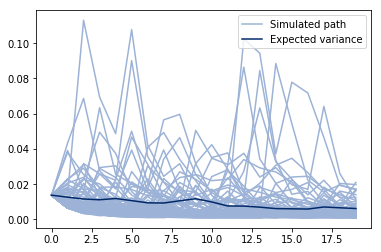

In [155]:
lines = plt.plot(sims.residual_variances[-1,::10,:].T, color='#9cb2d6')
lines[0].set_label('Simulated path')
plt.hold('on')
line = plt.plot(forecasts.variance.iloc[-1].values, color='#002868')
line[0].set_label('Expected variance')
legend = plt.legend()

In [97]:
mean_var = round(np.mean(ts_var), 9)

In [98]:
mean_var

4.45e-07

Since the training data had a very low average variance of 4.45e-07 (very close to zero!), the future expected variance is still low. However, the simulations show that it is very possible for the variance to increase over 0.1.

Below, I plot the simulated values of the returns over 20 minutes. The darker blue area shows the most likely returns.

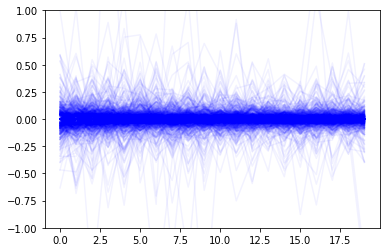

In [153]:
lines = plt.plot(sims.values[-1,:,:].T, color='blue', alpha=0.05)
lines[0].set_label('Simulated paths')
plt.ylim(-1, 1)
plt.show()

In [148]:
sims.values[-1,:,:].shape

(1000, 20)

In [166]:
np.min(sims.values[-1,:,:])

-1.882013372222638

In [165]:
np.min(np.prod(sims.values[-1,:,:]+1, axis=1))

-0.8590150060933599